In [35]:
import os
import sys
sys.path.append(os.getcwd())

from lib.models.model_execution_support import run_mod_with_correction_block_on_inputs_with_targets
from lib.models.model_execution_support import run_on_inputs_with_targets
from lib.models.potentially_recurrent_forecaster import PRForecaster
from lib.models.prerecorded_forecaster import PrerecordedForecaster
from lib.models.recurrent_forecaster_with_correction_block import RecurrentForecasterWithCorrectionBlock
from lib.models.recurrent_sigmoid_piecewise_forecaster import RSPForecaster, StackedRCellsForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import LSTMForecaster, GRUForecaster
from lib.models.linear_forecaster import LinearForecaster
from lib.utils.metrics import print_metrics
from lib.utils.recurrent_contexts_manager import RecurrentContextsManager

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd
import pandas_datareader.data as web
import xgboost

from typing import Any
from typing import Optional
from typing import Tuple
from uuid import uuid4
import datetime
import pickle
import time

In [36]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [37]:
DEVICE = 'cpu'
DTYPE = torch.float32

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

torch.set_printoptions(precision=10)

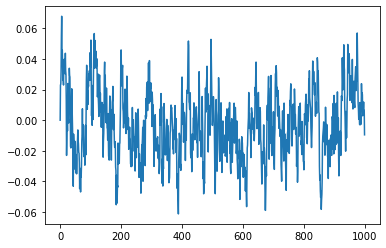

In [38]:
def gen_random_walk(length, max_abs_value):
    walk = [0]
    curr_value = 0
    walk_max_abs = 0
    for _ in range(length - 1):
        curr_value += np.random.normal(-curr_value / 5.)
        walk_max_abs = max(walk_max_abs, abs(curr_value))
        walk.append(curr_value)
    walk = torch.tensor(walk)
    return walk / walk_max_abs * max_abs_value


walk = gen_random_walk(1000, 0.068)
plt.plot(range(walk.shape[0]), walk)

In [39]:
df = pd.read_csv('heart_rate.csv')
print(df['T4'][890])
heart_data = np.array(df[:891]).transpose(1, 0)
heart_data = heart_data / (heart_data.max() - heart_data.min())
heart_data = heart_data - heart_data.mean()
print(heart_data)
print(heart_data.shape)

62.0
[[ 0.14598108  0.14598108  0.14204635 ...  0.4683017   0.45550151
   0.43827048]
 [ 0.28219521  0.28219521  0.27689336 ...  0.40076932  0.38879281
   0.38256881]
 [-0.30440775 -0.30440775 -0.30484894 ... -0.36155229 -0.35393276
  -0.34546305]
 [-0.32704289 -0.32704289 -0.32704289 ... -0.29516359 -0.26901976
  -0.2757001 ]]
(4, 891)


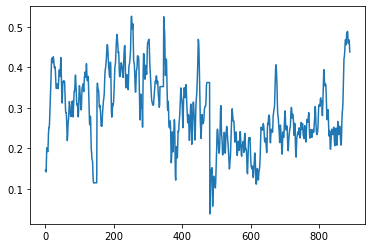

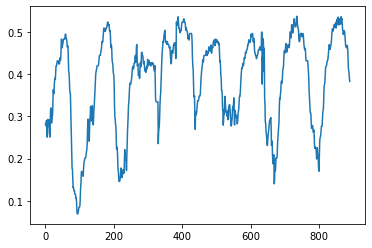

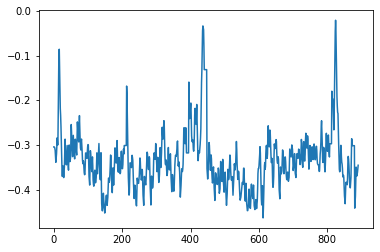

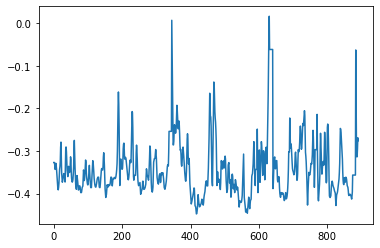

In [40]:
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[0, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[1, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[2, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[3, :])

In [41]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2023, 1, 1)

f = web.DataReader('^DJI', 'stooq', start, end)
ts = np.flip(f['Open'].values, axis=0).copy()
ts = ts / (ts.max() - ts.min())
ts = ts - ts.mean()
dji_ts = ts.copy()

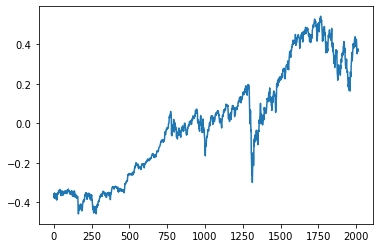

In [42]:
plt.figure()
plt.plot(range(len(dji_ts)), dji_ts)
plt.show()

Text(0.5, 1.0, 'Test')

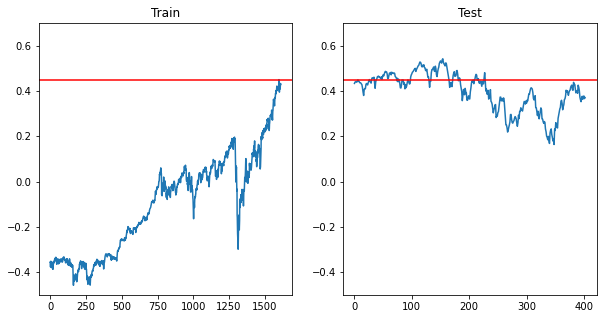

In [43]:
train_end = int(0.8 * len(ts))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(train_end), ts[:train_end], scalex=True, scaley=False)
plt.ylim(-0.5, 0.7)
plt.axhline(y=0.45, color='r')
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(range(len(ts[train_end:])), ts[train_end:])
plt.ylim(-0.5, 0.7)
plt.axhline(y=0.45, color='r')
plt.title('Test')

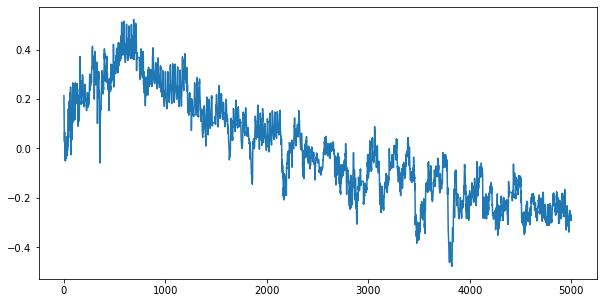

In [44]:
etth = pd.read_csv('/home/ivan/Downloads/ETTh1.csv')
ot_ts = np.array(etth['OT'])[:5000]
ot_ts = ot_ts / (ot_ts.max() - ot_ts.min())
ot_ts = ot_ts - ot_ts.mean()
plt.figure(figsize=(10, 5))
plt.plot(range(len(ot_ts)), ot_ts)

In [45]:
INP_SIZE = 2

def sw(t: torch.Tensor) -> torch.Tensor:
    return t.unfold(dimension=1, size=INP_SIZE, step=1)

def get_train_test_data_heart_rate(heart_data, train_ratio=0.9):
    N = heart_data.shape[1]
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = heart_data[:, :train_size]
    test_ts = heart_data[:, train_size:]
    return (
        sw(torch.from_numpy(train_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
    )


def get_train_test_data_from_ts(ts: np.ndarray, train_ratio=0.9):
    N = len(ts)
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = ts[:train_size]
    test_ts = ts[train_size:]
    return (
        sw(torch.from_numpy(train_ts[:-1]).view(1, train_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:-1]).view(1, test_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE)
    )


# inp, target, test_input, test_target = get_train_test_data_heart_rate(heart_data, train_ratio=0.8)

inp, target, test_input, test_target = get_train_test_data_from_ts(ts, train_ratio=0.8)
print(inp.shape, target.shape, test_input.shape, test_target.shape)
print(target.max())
print(test_target.max())

torch.Size([1609, 1, 2]) torch.Size([1609, 1, 1]) torch.Size([401, 1, 2]) torch.Size([401, 1, 1])
tensor(0.4499983490)
tensor(0.5420490503)


In [46]:
cm = RecurrentContextsManager()
baseline = LinearForecaster.find_optimal_least_squares_forecaster(cm, inp, target, bias=True)
print(baseline.predictor.weight.data)
print(baseline.predictor.bias.data)

tensor([[-0.0482982099,  1.0482109785]])
tensor([0.0004552625])


Metrics for linear train:
	 MSE: 0.0001280382857657969
	 MAE: 0.007261916995048523
	 MAPE: 0.16540735960006714


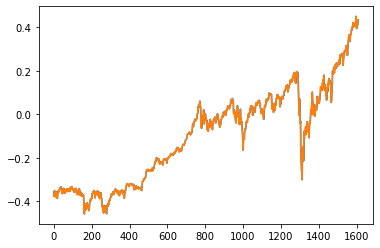

In [47]:
lin_train_out = run_on_inputs_with_targets(baseline, inp, target, setup_ctxs=False, delete_ctxs=False)
print_metrics(lin_train_out, target, 'linear train')
N, S, one = target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), lin_train_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
plt.show()

Metrics for linear test:
	 MSE: 0.00025157592608593404
	 MAE: 0.011981826275587082
	 MAPE: 0.03362544998526573


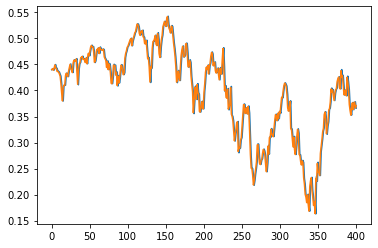

In [48]:
lin_test_out = run_on_inputs_with_targets(baseline, test_input, test_target,
                                                setup_ctxs=False, delete_ctxs=False)
print_metrics(lin_test_out, test_target, 'linear test')
N, S, one = test_target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), lin_test_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.show()

Metrics for xgboost train:
	 MSE: 2.0339270122349262e-05
	 MAE: 0.00328012160025537
	 MAPE: 0.09014645963907242


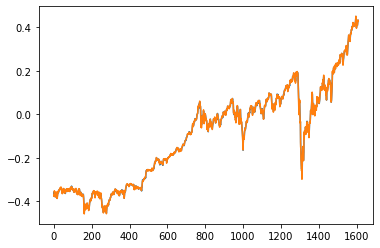

In [49]:
xgbreg = xgboost.XGBRegressor(objective='reg:squarederror')
N, S, M = inp.shape
inp_2d = inp.reshape(-1, M)
target_2d =target.reshape(-1, 1)
xgbreg.fit(inp_2d, target_2d)
out_2d = xgbreg.predict(inp_2d)
xgb_train_out = torch.from_numpy(out_2d.reshape(-1, S, 1))
N = target.shape[0]
plt.plot(np.arange(N), xgb_train_out[:, SEQ_IDX, :])
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
print_metrics(xgb_train_out, target, 'xgboost train')

Metrics for xgboost test:
	 MSE: 0.0010782082099467516
	 MAE: 0.024759044870734215
	 MAPE: 0.0603872612118721


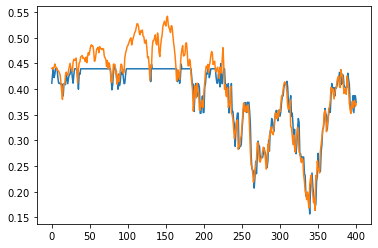

In [50]:
xgb_test_out = torch.from_numpy(xgbreg.predict(test_input.reshape(-1, M)).reshape(-1, S, 1))
N = test_target.shape[0]
plt.plot(np.arange(N), xgb_test_out[:, SEQ_IDX, :])
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
print_metrics(xgb_test_out, test_target, 'xgboost test')

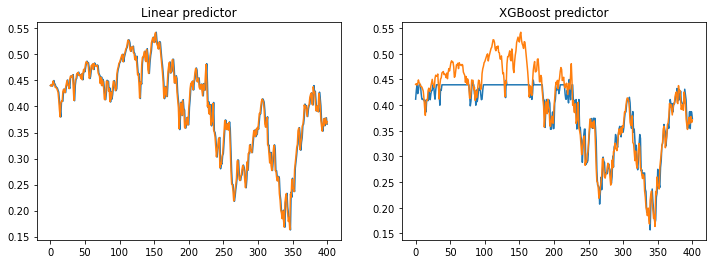

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(N), lin_test_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.title('Linear predictor')
plt.subplot(1, 2, 2)
plt.plot(np.arange(N), xgb_test_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.title('XGBoost predictor')
plt.show()

In [18]:
data = pd.DataFrame()
data['value'] = ts
data['series'] = 0
data['time_idx'] = range(len(ts))
data['static'] = 2
data.head()

,value,series,time_idx,static
0,-0.355947,0,0,2
1,-0.356031,0,1,2
2,-0.371099,0,2,2
3,-0.377247,0,3,2
4,-0.366928,0,4,2


In [65]:
max_encoder_length = 60
max_prediction_length = 1 # 20

context_length = max_encoder_length
prediction_length = max_prediction_length

training_cutoff = int(len(ts) * 0.9)

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [69]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE().to(device='cpu')(baseline_predictions.to(device='cpu'), actuals.to(device='cpu'))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.0461136103)

In [67]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/lightning/pytorch/loops/utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.3548133892335755
Restoring states from the checkpoint path at /home/ivan/my_projects/nau_forecasting/.lr_find_efabfa1f-4f4c-4db3-88d4-824743d3a847.ckpt
Restored all states from the checkpoint at /home/ivan/my_projects/nau_forecasting/.lr_find_efabfa1f-4f4c-4db3-88d4-824743d3a847.ckpt


suggested learning rate: 0.3548133892335755


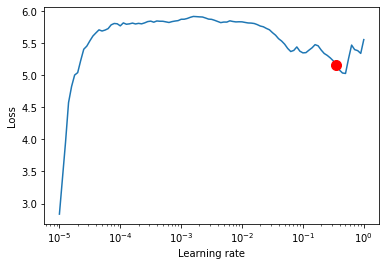

/tmp/ipykernel_26957/330161667.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [68]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [75]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=0.01,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.735     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [76]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1316, 1])
torch.Size([1316, 1])
1316
Metrics for Nbeats train:
	 MSE: 0.00018141431792173535
	 MAE: 0.007661908399313688
	 MAPE: 0.062557153403759


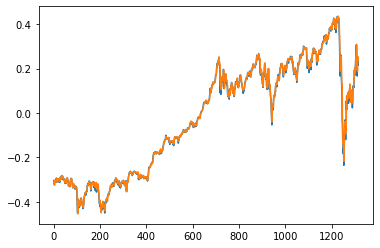

In [92]:
dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)
actuals = torch.cat([y[0] for x, y in iter(dataloader)]).cpu()
predictions = best_model.predict(dataloader).cpu()
N = len(predictions)
plt.plot(np.arange(N), actuals)
plt.plot(np.arange(N), predictions)
print_metrics(actuals, predictions, 'Nbeats train')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics for Nbeats test:
	 MSE: 0.0004390451649669558
	 MAE: 0.015731660649180412
	 MAPE: 0.047892022877931595


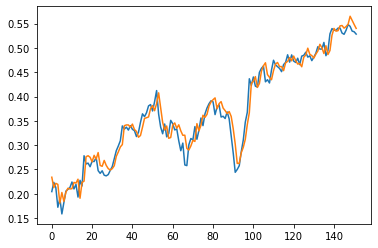

In [93]:
dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)
actuals = torch.cat([y[0] for x, y in iter(dataloader)]).cpu()
predictions = best_model.predict(dataloader).cpu()
N = len(predictions)
plt.plot(np.arange(N), actuals)
plt.plot(np.arange(N), predictions)
print_metrics(actuals, predictions, 'Nbeats test')

In [62]:
preds, x, *_ = best_model.predict(val_dataloader, mode="raw", return_x=True)
print(len(actuals))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


133


Metrics for baseline train:
	 MSE: 0.0001280382857657969
	 MAE: 0.007261916995048523
	 MAPE: 0.16540735960006714
Metrics for baseline test:
	 MSE: 0.00025157592608593404
	 MAE: 0.011981826275587082
	 MAPE: 0.03362544998526573
tensor(0.1157867461)
tensor(0.0689026266)
tensor(0.0001280383)
tensor(0.0002515759)


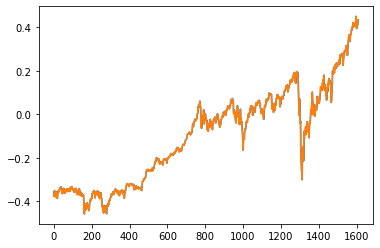

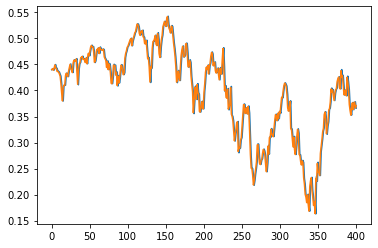

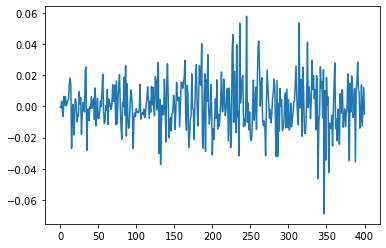

In [18]:
train_out = lin_train_out.detach()
test_out = lin_test_out.detach()
print_metrics(train_out, target, 'baseline train')
print_metrics(test_out, test_target, 'baseline test')
print((train_out - target).abs().max())
print((test_out - test_target).abs().max())
print((train_out - target).square().mean())
print((test_out - test_target).square().mean())
N = train_out.shape[0]
plt.figure()
plt.plot(range(N), train_out.squeeze().numpy())
plt.plot(range(N), target.squeeze().numpy())
N = test_out.shape[0]
plt.figure()
plt.plot(range(N), test_out.squeeze().numpy())
plt.plot(range(N), test_target.squeeze().numpy())
plt.figure()
plt.plot(range(N), test_out.squeeze().numpy() - test_target.squeeze().numpy())

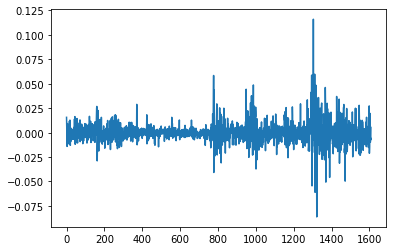

In [19]:
N = train_out.shape[0]
plt.plot(range(N), train_out.squeeze().numpy() - target.squeeze().numpy())

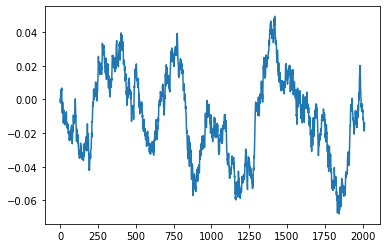

In [113]:
def gen_random_walk(length, max_abs_value, denom=1.8):
    walk = [0]
    curr_value = 0
    walk_max_abs = 0
    for _ in range(length - 1):
        curr_value += np.random.normal(-curr_value / denom)
        walk_max_abs = max(walk_max_abs, abs(curr_value))
        walk.append(curr_value)
    walk = torch.tensor(walk)
    return walk / walk_max_abs * max_abs_value

walk = gen_random_walk(N, max_abs_value=0.068, denom=200)
plt.plot(range(walk.shape[0]), walk)

torch.Size([1609, 1, 1])
torch.Size([1609])
torch.Size([1609, 1, 1])


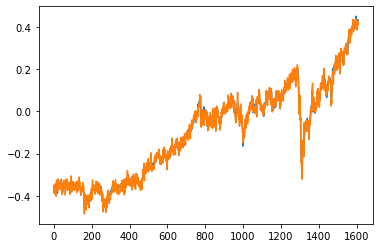

In [21]:
print(train_out.shape)
N = train_out.shape[0]
walk = gen_random_walk(N, 0.068, denom=1.5)
print(walk.shape)
upd = train_out + walk[:, None, None]
print(upd.shape)
plt.plot(range(N), train_out.squeeze().detach().numpy())
plt.plot(range(N), upd.squeeze().detach().numpy())

In [120]:
HIDDEN_SIZE = 32
NUM_CELLS = 4
LR = 0.01
STEPS = 2000

start = time.perf_counter_ns()

# INP_SIZE + 4 because correction block also takes baseline
# forecast, previous baseline error, previous correction and
# previous actual error as extra inputs
corrector = StackedRCellsForecaster(cm, INP_SIZE + 4, HIDDEN_SIZE, NUM_CELLS,
                                   CellType=RSPForecaster) # RSPForecaster(cm, INP_SIZE + 3, HIDDEN_SIZE)  

NOISE_MIN = 0.03
NOISE_MAX = 0.09
DENOM_MIN = 3
DENOM_MAX = 200


#baseline = PrerecordedForecaster(cm, train_out, test_out)
baseline = LinearForecaster.find_optimal_least_squares_forecaster(cm, inp, target, bias=True)

model = RecurrentForecasterWithCorrectionBlock(cm, baseline, corrector, correction_scaling='unconstrained',
                                              inp_len=INP_SIZE)

best_test_loss = None
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(model.parameters(), lr=LR)# optim.LBFGS(model.parameters(), lr=LR) # optim.SGD(model.parameters(), lr=LR) #
N = len(ts)
train_size = int(N * 0.8)

test_losses = []
#begin to train
for i in range(STEPS):
    NOISE = np.random.uniform(low=NOISE_MIN, high=NOISE_MAX)
    DENOM = np.random.uniform(low=DENOM_MIN, high=DENOM_MAX)
    noise = gen_random_walk(train_size, NOISE, DENOM)
    inp_wnoise = inp + sw(noise[:-1].view(1, train_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE)
    target_wnoise = target + noise[INP_SIZE:][:, None, None].to(DEVICE, dtype=DTYPE)
    #train_out_with_noise = train_out + gen_random_walk(train_out.shape[0], NOISE, DENOM)[:, None, None] #torch.randn_like(train_out) * NOISE
    #baseline.train_targets = train_out_with_noise
    print('STEP: ', i)
    if isinstance(optimizer, optim.LBFGS):
        def closure():
            optimizer.zero_grad()
            out, corrections = run_mod_with_correction_block_on_inputs_with_targets(
                model, inp_wnoise, target_wnoise, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
            loss = criterion(out, target_wnoise)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    else:
        optimizer.zero_grad()
        out, corrections = run_mod_with_correction_block_on_inputs_with_targets(
            model, inp_wnoise, target_wnoise, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
        loss = criterion(out, target_wnoise)
        print('loss: ', loss.item())
        loss.backward()
        optimizer.step()
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred, corrections = run_mod_with_correction_block_on_inputs_with_targets(
            model, test_input, test_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)
        loss = criterion(pred, test_target)
        print('test loss:', loss.item())
        tst_loss = loss.item()
        if best_test_loss is None or tst_loss < best_test_loss:
            best_test_loss = tst_loss
            torch.save(model.state_dict(), 'best_chkpt.pt')
        test_losses.append(loss.item())
    
end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')
print(f'Min test loss: {min(test_losses)}')

STEP:  0
loss:  0.0029565056320279837
test loss: 0.013041546568274498
STEP:  1
loss:  0.004451139364391565
test loss: 0.0028658341616392136
STEP:  2
loss:  0.0008135363459587097
test loss: 0.0015102872857823968
STEP:  3
loss:  0.00066997273825109
test loss: 0.0011047804728150368
STEP:  4
loss:  0.0003131920821033418
test loss: 0.0006189442938193679
STEP:  5
loss:  0.00040536592132411897
test loss: 0.0004433294525370002
STEP:  6
loss:  0.0001683421724010259
test loss: 0.0003417766420170665
STEP:  7
loss:  0.0002638270962052047
test loss: 0.0002612291427794844
STEP:  8
loss:  0.0002543610753491521
test loss: 0.00028723408468067646
STEP:  9
loss:  0.00018060553702525795
test loss: 0.0005154419923201203
STEP:  10
loss:  0.00018430346972309053
test loss: 0.0005363947129808366
STEP:  11
loss:  0.00019759259885177016
test loss: 0.00032951461616903543
STEP:  12
loss:  0.00016099412459880114
test loss: 0.0002509751357138157
STEP:  13
loss:  0.00014064509014133364
test loss: 0.000290819734800606

test loss: 0.0002515109663363546
STEP:  113
loss:  0.00013267147005535662
test loss: 0.0002514366351533681
STEP:  114
loss:  0.0001380277390126139
test loss: 0.0002513773797545582
STEP:  115
loss:  0.00014327128883451223
test loss: 0.000251349585596472
STEP:  116
loss:  0.00014025384734850377
test loss: 0.00025132179143838584
STEP:  117
loss:  0.00014562212163582444
test loss: 0.00025130267022177577
STEP:  118
loss:  0.00012995002907700837
test loss: 0.0002512877690605819
STEP:  119
loss:  0.00013259475235827267
test loss: 0.00025128829292953014
STEP:  120
loss:  0.0001292901288252324
test loss: 0.0002513015060685575
STEP:  121
loss:  0.0001382399204885587
test loss: 0.00025133887538686395
STEP:  122
loss:  0.00014201192243490368
test loss: 0.00025138616911135614
STEP:  123
loss:  0.0001362596667604521
test loss: 0.0002514741208869964
STEP:  124
loss:  0.0001330418308498338
test loss: 0.0002515877422410995
STEP:  125
loss:  0.0001743652392178774
test loss: 0.0002516715321689844
STEP:  

test loss: 0.00025143445236608386
STEP:  224
loss:  0.0001453359000151977
test loss: 0.00025147569249384105
STEP:  225
loss:  0.00013261039566714317
test loss: 0.00025155357434414327
STEP:  226
loss:  0.00014718958118464798
test loss: 0.0002516433014534414
STEP:  227
loss:  0.00012844454613514245
test loss: 0.00025174501934088767
STEP:  228
loss:  0.00013850438699591905
test loss: 0.00025183192337863147
STEP:  229
loss:  0.00014903920236974955
test loss: 0.00025187208666466177
STEP:  230
loss:  0.0001511583395767957
test loss: 0.0002519114641472697
STEP:  231
loss:  0.00013361895980779082
test loss: 0.0002519272093195468
STEP:  232
loss:  0.00014731059491168708
test loss: 0.0002519277622923255
STEP:  233
loss:  0.0001294402900384739
test loss: 0.00025193148758262396
STEP:  234
loss:  0.0001327588252024725
test loss: 0.0002519070403650403
STEP:  235
loss:  0.00014103967987466604
test loss: 0.0002518846304155886
STEP:  236
loss:  0.00013630067405756563
test loss: 0.0002518275287002325
ST

loss:  0.00012883507588412613
test loss: 0.0002631277311593294
STEP:  335
loss:  0.00016143760876730084
test loss: 0.00026411694125272334
STEP:  336
loss:  0.00012777726806234568
test loss: 0.0002652470429893583
STEP:  337
loss:  0.00015537560102529824
test loss: 0.0002665291540324688
STEP:  338
loss:  0.00013717406545765698
test loss: 0.0002677937736734748
STEP:  339
loss:  0.00013444841897580773
test loss: 0.0002691635745577514
STEP:  340
loss:  0.0001341829338343814
test loss: 0.0002708168176468462
STEP:  341
loss:  0.00014550414925906807
test loss: 0.000271880766376853
STEP:  342
loss:  0.00014917962835170329
test loss: 0.00027301415684632957
STEP:  343
loss:  0.00013410000246949494
test loss: 0.0002740558120422065
STEP:  344
loss:  0.00016344335745088756
test loss: 0.00027414955548010767
STEP:  345
loss:  0.00013660718104802072
test loss: 0.0002741477801464498
STEP:  346
loss:  0.00013978472270537168
test loss: 0.0002736402675509453
STEP:  347
loss:  0.0001416747982148081
test los

loss:  0.00011411571176722646
test loss: 0.0002659476886037737
STEP:  446
loss:  0.00010757175914477557
test loss: 0.00026603302103467286
STEP:  447
loss:  0.00012202495418023318
test loss: 0.0002692174166440964
STEP:  448
loss:  0.0001199330945382826
test loss: 0.00027192363631911576
STEP:  449
loss:  0.00010563083924353123
test loss: 0.0002791258448269218
STEP:  450
loss:  0.0001035436216625385
test loss: 0.00027728898567147553
STEP:  451
loss:  0.0001613133936189115
test loss: 0.0002629559312481433
STEP:  452
loss:  0.00010585524432826787
test loss: 0.0002577786799520254
STEP:  453
loss:  0.0001560779637657106
test loss: 0.0002546696050558239
STEP:  454
loss:  0.00012398287071846426
test loss: 0.0002529576304368675
STEP:  455
loss:  0.00011020963574992493
test loss: 0.0002529093180783093
STEP:  456
loss:  0.0001200333281303756
test loss: 0.0002545966999605298
STEP:  457
loss:  0.00012191773566883057
test loss: 0.00025836267741397023
STEP:  458
loss:  0.00011131448991363868
test loss

loss:  9.583049541106448e-05
test loss: 0.000300195679301396
STEP:  557
loss:  9.589508408680558e-05
test loss: 0.00028964728699065745
STEP:  558
loss:  0.00022064214863348752
test loss: 0.0002729790285229683
STEP:  559
loss:  0.00010159989324165508
test loss: 0.00026594146038405597
STEP:  560
loss:  9.685404802439734e-05
test loss: 0.00026306675863452256
STEP:  561
loss:  0.00013403348566498607
test loss: 0.0002613675897009671
STEP:  562
loss:  9.982699702959508e-05
test loss: 0.00026253930991515517
STEP:  563
loss:  0.00010129759175470099
test loss: 0.0002661102043930441
STEP:  564
loss:  0.00010089190618600696
test loss: 0.00027226831298321486
STEP:  565
loss:  0.00010918808402493596
test loss: 0.0002802125527523458
STEP:  566
loss:  9.874725219560787e-05
test loss: 0.0002880140673369169
STEP:  567
loss:  9.864623280009255e-05
test loss: 0.00029189305496402085
STEP:  568
loss:  0.0001058578782249242
test loss: 0.00028851343085989356
STEP:  569
loss:  0.0001327927748207003
test loss:

test loss: 0.0003107846132479608
STEP:  668
loss:  0.00010338791616959497
test loss: 0.00027341998065821826
STEP:  669
loss:  0.0001229834888363257
test loss: 0.00025811049272306263
STEP:  670
loss:  0.00019494295702315867
test loss: 0.0002553770609665662
STEP:  671
loss:  0.00011730619007721543
test loss: 0.0002550974313635379
STEP:  672
loss:  0.00011003210238413885
test loss: 0.00025662765256129205
STEP:  673
loss:  9.965203935280442e-05
test loss: 0.00026058743242174387
STEP:  674
loss:  9.277467324864119e-05
test loss: 0.00026517672813497484
STEP:  675
loss:  9.762985428096727e-05
test loss: 0.00026809924747794867
STEP:  676
loss:  0.00011926110892090946
test loss: 0.0002690483524929732
STEP:  677
loss:  9.294621122535318e-05
test loss: 0.00026958424132317305
STEP:  678
loss:  8.896579674910754e-05
test loss: 0.00027301363297738135
STEP:  679
loss:  0.0001703866000752896
test loss: 0.0002773587766569108
STEP:  680
loss:  0.00010444933286635205
test loss: 0.0002870383614208549
STEP

loss:  0.00015456527762580663
test loss: 0.0002709835534915328
STEP:  780
loss:  8.084274304565042e-05
test loss: 0.00028221620596013963
STEP:  781
loss:  8.448200242128223e-05
test loss: 0.0003021279408130795
STEP:  782
loss:  8.950367919169366e-05
test loss: 0.0003433682140894234
STEP:  783
loss:  7.893244765000418e-05
test loss: 0.0003407726180739701
STEP:  784
loss:  9.482548921369016e-05
test loss: 0.0003152851131744683
STEP:  785
loss:  7.745732727926224e-05
test loss: 0.00030459085246548057
STEP:  786
loss:  8.673839329276234e-05
test loss: 0.0003019885625690222
STEP:  787
loss:  7.659354014322162e-05
test loss: 0.0003095754946116358
STEP:  788
loss:  0.00013824840425513685
test loss: 0.0003299361851532012
STEP:  789
loss:  7.53503481973894e-05
test loss: 0.00036897961399517953
STEP:  790
loss:  0.00024065437901299447
test loss: 0.0003354816872160882
STEP:  791
loss:  8.196853013942018e-05
test loss: 0.0003176757600158453
STEP:  792
loss:  8.858658839017153e-05
test loss: 0.0003

loss:  8.009938028408214e-05
test loss: 0.0003200159699190408
STEP:  892
loss:  7.274606468854472e-05
test loss: 0.00032737242872826755
STEP:  893
loss:  7.315332186408341e-05
test loss: 0.00036038042162545025
STEP:  894
loss:  0.0001426266535418108
test loss: 0.0003909263468813151
STEP:  895
loss:  7.973318133736029e-05
test loss: 0.0003974047431256622
STEP:  896
loss:  0.00010659937834134325
test loss: 0.0003411613288335502
STEP:  897
loss:  6.962374754948542e-05
test loss: 0.00031261148978956044
STEP:  898
loss:  0.00010646381269907579
test loss: 0.0003013578534591943
STEP:  899
loss:  8.646122296340764e-05
test loss: 0.0003166339884046465
STEP:  900
loss:  7.219507824629545e-05
test loss: 0.0003435051767155528
STEP:  901
loss:  7.271526555996388e-05
test loss: 0.00035689526703208685
STEP:  902
loss:  6.669542926829308e-05
test loss: 0.00037029574741609395
STEP:  903
loss:  7.061198266455904e-05
test loss: 0.00037861030432395637
STEP:  904
loss:  6.37570847175084e-05
test loss: 0.00

loss:  8.013799379114062e-05
test loss: 0.00034063373459503055
STEP:  1004
loss:  6.155346636660397e-05
test loss: 0.000301268941257149
STEP:  1005
loss:  7.772014214424416e-05
test loss: 0.00029149939655326307
STEP:  1006
loss:  9.366269659949467e-05
test loss: 0.00029832436121068895
STEP:  1007
loss:  6.249798025237396e-05
test loss: 0.00031736146775074303
STEP:  1008
loss:  6.794709770474583e-05
test loss: 0.00034712901106104255
STEP:  1009
loss:  5.771514406660572e-05
test loss: 0.00036977819399908185
STEP:  1010
loss:  0.00020475905330386013
test loss: 0.00034784787567332387
STEP:  1011
loss:  5.795486140414141e-05
test loss: 0.00032010310678742826
STEP:  1012
loss:  0.00010971722076646984
test loss: 0.00030085828620940447
STEP:  1013
loss:  6.916315032867715e-05
test loss: 0.00030393197084777057
STEP:  1014
loss:  6.233993190107867e-05
test loss: 0.0003122997295577079
STEP:  1015
loss:  7.090129656717181e-05
test loss: 0.0003313479828648269
STEP:  1016
loss:  0.000117129180580377

loss:  5.9364920161897317e-05
test loss: 0.0003457459679339081
STEP:  1114
loss:  4.777928188559599e-05
test loss: 0.0003381979186087847
STEP:  1115
loss:  8.349966810783371e-05
test loss: 0.00033331685699522495
STEP:  1116
loss:  0.0001374511484755203
test loss: 0.00032740089227445424
STEP:  1117
loss:  0.0001188164169434458
test loss: 0.00032506699790246785
STEP:  1118
loss:  0.00017758457397576421
test loss: 0.00032747405930422246
STEP:  1119
loss:  8.812142186798155e-05
test loss: 0.00034264387795701623
STEP:  1120
loss:  6.895014666952193e-05
test loss: 0.0003657042980194092
STEP:  1121
loss:  5.965009404462762e-05
test loss: 0.0003885998739860952
STEP:  1122
loss:  6.25350876362063e-05
test loss: 0.00040360342245548964
STEP:  1123
loss:  8.835805056151003e-05
test loss: 0.00036917353281751275
STEP:  1124
loss:  4.7446537791984156e-05
test loss: 0.0003457328421063721
STEP:  1125
loss:  7.38372327759862e-05
test loss: 0.00032728310907259583
STEP:  1126
loss:  8.808320853859186e-05


loss:  4.4906446419190615e-05
test loss: 0.0003319020033814013
STEP:  1224
loss:  9.41849866649136e-05
test loss: 0.00034145277459174395
STEP:  1225
loss:  0.00011815398465842009
test loss: 0.00035350583493709564
STEP:  1226
loss:  5.226249777479097e-05
test loss: 0.00035608356120064855
STEP:  1227
loss:  5.285572478896938e-05
test loss: 0.0003528360102791339
STEP:  1228
loss:  8.396375778829679e-05
test loss: 0.00034917533048428595
STEP:  1229
loss:  4.192205233266577e-05
test loss: 0.0003481933381408453
STEP:  1230
loss:  4.8863832489587367e-05
test loss: 0.0003526625514496118
STEP:  1231
loss:  0.00011681573960231617
test loss: 0.000345733918948099
STEP:  1232
loss:  7.836245640646666e-05
test loss: 0.0003457296115811914
STEP:  1233
loss:  7.596956129418686e-05
test loss: 0.0003477002028375864
STEP:  1234
loss:  4.610569158103317e-05
test loss: 0.0003575481241568923
STEP:  1235
loss:  4.535972766461782e-05
test loss: 0.0003696199564728886
STEP:  1236
loss:  6.596820458071306e-05
tes

loss:  5.250869071460329e-05
test loss: 0.00032883428502827883
STEP:  1334
loss:  4.0718554373597726e-05
test loss: 0.0003323794808238745
STEP:  1335
loss:  6.513702101074159e-05
test loss: 0.0003340398834552616
STEP:  1336
loss:  6.75475675961934e-05
test loss: 0.0003357520326972008
STEP:  1337
loss:  5.7214208936784416e-05
test loss: 0.0003306964645162225
STEP:  1338
loss:  4.673466901294887e-05
test loss: 0.00032746882061474025
STEP:  1339
loss:  8.429109584540129e-05
test loss: 0.00033330891164951026
STEP:  1340
loss:  4.861786146648228e-05
test loss: 0.0003303223929833621
STEP:  1341
loss:  5.703339047613554e-05
test loss: 0.0003296742506790906
STEP:  1342
loss:  4.4229771447135136e-05
test loss: 0.0003403799782972783
STEP:  1343
loss:  4.917288606520742e-05
test loss: 0.0003476497367955744
STEP:  1344
loss:  0.00014384901442099363
test loss: 0.00035513463080860674
STEP:  1345
loss:  6.43586172373034e-05
test loss: 0.0003491548413876444
STEP:  1346
loss:  5.20805042469874e-05
test

loss:  5.29007738805376e-05
test loss: 0.00035732940887100995
STEP:  1444
loss:  3.639702481450513e-05
test loss: 0.0003408954362384975
STEP:  1445
loss:  3.325820216559805e-05
test loss: 0.0003292066976428032
STEP:  1446
loss:  4.1122759284917265e-05
test loss: 0.00033029820770025253
STEP:  1447
loss:  4.551456368062645e-05
test loss: 0.00033446686575189233
STEP:  1448
loss:  8.144112507579848e-05
test loss: 0.000343483203323558
STEP:  1449
loss:  8.204745972761884e-05
test loss: 0.00035414626472629607
STEP:  1450
loss:  3.650572762126103e-05
test loss: 0.00035717347054742277
STEP:  1451
loss:  3.729703530552797e-05
test loss: 0.00035248236963525414
STEP:  1452
loss:  4.4440999772632495e-05
test loss: 0.0003396184474695474
STEP:  1453
loss:  4.185142461210489e-05
test loss: 0.00033137938589788973
STEP:  1454
loss:  5.137975313118659e-05
test loss: 0.0003248157736379653
STEP:  1455
loss:  3.9816994103603065e-05
test loss: 0.00032516667852178216
STEP:  1456
loss:  4.9396479880670086e-05

loss:  4.138650911045261e-05
test loss: 0.00032783596543595195
STEP:  1554
loss:  3.3476004318799824e-05
test loss: 0.0003268525761086494
STEP:  1555
loss:  3.497183570289053e-05
test loss: 0.00032047543209046125
STEP:  1556
loss:  4.618526509148069e-05
test loss: 0.0003114089195150882
STEP:  1557
loss:  6.025218317518011e-05
test loss: 0.000307342765154317
STEP:  1558
loss:  6.476360431406647e-05
test loss: 0.00030445208540186286
STEP:  1559
loss:  5.0168124289484695e-05
test loss: 0.0003067167126573622
STEP:  1560
loss:  4.649708716897294e-05
test loss: 0.0003157589817419648
STEP:  1561
loss:  3.2864350941963494e-05
test loss: 0.0003253066970501095
STEP:  1562
loss:  3.3044729207176715e-05
test loss: 0.00032834926969371736
STEP:  1563
loss:  5.40108849236276e-05
test loss: 0.00032147669116966426
STEP:  1564
loss:  3.443309833528474e-05
test loss: 0.0003194895980414003
STEP:  1565
loss:  0.0001158386075985618
test loss: 0.0003146456438116729
STEP:  1566
loss:  4.681997961597517e-05
te

loss:  4.2568564822431654e-05
test loss: 0.0003106475924141705
STEP:  1664
loss:  3.0504375899909064e-05
test loss: 0.0003120390756521374
STEP:  1665
loss:  4.563235052046366e-05
test loss: 0.0003135370498057455
STEP:  1666
loss:  0.00019435552530921996
test loss: 0.0003137183375656605
STEP:  1667
loss:  2.9206574254203588e-05
test loss: 0.00031037090229801834
STEP:  1668
loss:  3.517963705235161e-05
test loss: 0.0003058095753658563
STEP:  1669
loss:  4.598729356075637e-05
test loss: 0.0003043661708943546
STEP:  1670
loss:  3.097454464295879e-05
test loss: 0.0003030968946404755
STEP:  1671
loss:  6.21719445916824e-05
test loss: 0.0003025395853910595
STEP:  1672
loss:  5.9736688854172826e-05
test loss: 0.0003027070197276771
STEP:  1673
loss:  3.1168277928372845e-05
test loss: 0.00030280405189841986
STEP:  1674
loss:  6.430194480344653e-05
test loss: 0.0003021920274477452
STEP:  1675
loss:  4.0284015994984657e-05
test loss: 0.00029824921512044966
STEP:  1676
loss:  3.0741008231416345e-05

loss:  8.08974145911634e-05
test loss: 0.00027812353800982237
STEP:  1774
loss:  5.464664354803972e-05
test loss: 0.0002844562695827335
STEP:  1775
loss:  4.7159832320176065e-05
test loss: 0.0002992898225784302
STEP:  1776
loss:  7.263344014063478e-05
test loss: 0.00029562789131887257
STEP:  1777
loss:  3.0030465495656244e-05
test loss: 0.00028046738589182496
STEP:  1778
loss:  4.490413630264811e-05
test loss: 0.0002755737805273384
STEP:  1779
loss:  3.747936352738179e-05
test loss: 0.00028090926934964955
STEP:  1780
loss:  2.7978341677226126e-05
test loss: 0.00029041527886874974
STEP:  1781
loss:  3.126309093204327e-05
test loss: 0.0002955207310151309
STEP:  1782
loss:  3.7189387512626126e-05
test loss: 0.0002965638122987002
STEP:  1783
loss:  3.2312902476405725e-05
test loss: 0.00029735645512118936
STEP:  1784
loss:  4.8937414248939604e-05
test loss: 0.000297390331979841
STEP:  1785
loss:  3.37650126311928e-05
test loss: 0.0002945261949207634
STEP:  1786
loss:  3.910134910256602e-05


loss:  3.59512196155265e-05
test loss: 0.00028399063739925623
STEP:  1884
loss:  2.928814137703739e-05
test loss: 0.00028687308076769114
STEP:  1885
loss:  4.260302011971362e-05
test loss: 0.0002902565465774387
STEP:  1886
loss:  3.89277447538916e-05
test loss: 0.00029328680830076337
STEP:  1887
loss:  3.768581154872663e-05
test loss: 0.0003024619072675705
STEP:  1888
loss:  6.677410419797525e-05
test loss: 0.0003032282693311572
STEP:  1889
loss:  4.912844451609999e-05
test loss: 0.00030125549528747797
STEP:  1890
loss:  5.009310189052485e-05
test loss: 0.0003026960475835949
STEP:  1891
loss:  2.7911697543459013e-05
test loss: 0.00030064317979849875
STEP:  1892
loss:  4.768809594679624e-05
test loss: 0.0002998171839863062
STEP:  1893
loss:  3.938210284104571e-05
test loss: 0.0002985159517265856
STEP:  1894
loss:  4.2447827581781894e-05
test loss: 0.00029494482441805303
STEP:  1895
loss:  2.7463382139103487e-05
test loss: 0.00029065838316455483
STEP:  1896
loss:  5.538661571335979e-05
t

loss:  2.8909542379551567e-05
test loss: 0.00028578779892995954
STEP:  1994
loss:  4.716665716841817e-05
test loss: 0.0002839055086951703
STEP:  1995
loss:  0.00010106511763297021
test loss: 0.0002845697745215148
STEP:  1996
loss:  2.40039880736731e-05
test loss: 0.00028397547430358827
STEP:  1997
loss:  2.5145947802229784e-05
test loss: 0.0002842388639692217
STEP:  1998
loss:  3.843395097646862e-05
test loss: 0.00028459858731366694
STEP:  1999
loss:  2.6651441658032127e-05
test loss: 0.0002847653813660145
Elapsed time: 4587.982578998 seconds.
Min test loss: 0.0002509751357138157


In [124]:
HIDDEN_SIZE = 6
NUM_CELLS = 2
LR = 0.08
STEPS = 100

start = time.perf_counter_ns()

corrector = StackedRCellsForecaster(cm, INP_SIZE, HIDDEN_SIZE, NUM_CELLS, CellType=LSTMForecaster)

train_out = lin_train_out.detach()
test_out = lin_test_out.detach()

corrector_train_target = (target - train_out).detach()
corrector_test_target = (test_target - test_out).detach()
model = corrector

best_test_loss = None
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(model.parameters(), lr=LR)# optim.SGD(model.parameters(), lr=LR) #optim.LBFGS(model.parameters(), lr=LR)
test_losses = []
#begin to train
for i in range(STEPS):
    print('STEP: ', i)
    if isinstance(optimizer, optim.LBFGS):
        def closure():
            optimizer.zero_grad()
            out = run_on_inputs_with_targets(
                model, inp, corrector_train_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
            loss = criterion(out, corrector_train_target)
            print('loss:', loss.item())
            loss.backward()#retain_graph=True)
            return loss
        optimizer.step(closure)
    else:
        optimizer.zero_grad()
        out = run_on_inputs_with_targets(
            model, inp, corrector_train_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
        loss = criterion(out, corrector_train_target)
        print('loss: ', loss.item())
        loss.backward()#retain_graph=True)
        optimizer.step()
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = run_on_inputs_with_targets(
            model, test_input, corrector_test_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)
        loss = criterion(pred, corrector_test_target)
        print('test loss:', loss.item())
        tst_loss = loss.item()
        if best_test_loss is None or tst_loss < best_test_loss:
            best_test_loss = tst_loss
            torch.save(model.state_dict(), 'best_chkpt.pt')
        test_losses.append(loss.item())

end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')
print(f'Min test loss: {min(test_losses)}')

STEP:  0
loss:  0.01140512339770794
test loss: 0.1488180309534073
STEP:  1
loss:  0.2139711081981659
test loss: 0.001308696810156107
STEP:  2
loss:  0.00427586492151022
test loss: 0.01595117896795273
STEP:  3
loss:  0.016148962080478668
test loss: 0.02965300716459751
STEP:  4
loss:  0.0335172563791275
test loss: 0.032024085521698
STEP:  5
loss:  0.03672192245721817
test loss: 0.028543012216687202
STEP:  6
loss:  0.031352732330560684
test loss: 0.022524381056427956
STEP:  7
loss:  0.022240590304136276
test loss: 0.015819966793060303
STEP:  8
loss:  0.01286371424794197
test loss: 0.00958980992436409
STEP:  9
loss:  0.005613669753074646
test loss: 0.004645106848329306
STEP:  10
loss:  0.0018348278244957328
test loss: 0.0015423023141920567
STEP:  11
loss:  0.001710683573037386
test loss: 0.000444564939243719
STEP:  12
loss:  0.004124292638152838
test loss: 0.0008802805095911026
STEP:  13
loss:  0.006936812307685614
test loss: 0.0019051170675083995
STEP:  14
loss:  0.008230650797486305
test

In [18]:
from dataclasses import dataclass
from typing import List

@dataclass
class DoShitResults:
    epoch_errors_train: List[float]
    epoch_errors_val: List[float]
    time_per_epoch: List[float]
        
tst = DoShitResults([2., 3.], [3., 4.], [5., 6.])

In [53]:
import abc

def do_shit(time_series: np.ndarray,
            cell_type: abc.ABCMeta,
            inp_size: int,
            hidden_size: int,
            num_cells: int,
            max_epochs: int,
            lr: float,
            do_print=True,
            do_plot=False,
            val_freq=5,
            get_train_val_data_fn=get_train_test_data_from_ts) -> DoShitResults:
    global INP_SIZE
    INP_SIZE = inp_size
    train_inp, train_targ, test_inp, test_targ = get_train_val_data_fn(time_series, train_ratio=0.8)

    cm = RecurrentContextsManager()
    baseline = LinearForecaster.find_optimal_least_squares_forecaster(cm, train_inp, train_targ, bias=True)
    lin_train_out = run_on_inputs_with_targets(baseline, train_inp, train_targ,
                                               setup_ctxs=False, delete_ctxs=False)
    lin_test_out = run_on_inputs_with_targets(baseline, test_inp, test_targ,
                                               setup_ctxs=False, delete_ctxs=False)
    
    corrector = StackedRCellsForecaster(cm, inp_size, hidden_size, num_cells, CellType=cell_type)

    corrector_train_target = (train_targ - lin_train_out).detach()
    maxmindist = corrector_train_target.max() - corrector_train_target.min()
    corrector_train_target = corrector_train_target / maxmindist
    mean = corrector_train_target.mean()
    corrector_train_target = corrector_train_target - mean
#     mean, std = corrector_train_target.mean(), corrector_train_target.std()
#     corrector_train_target = (corrector_train_target - mean) / std
#     plt.figure()
#     plt.plot(range(corrector_train_target.shape[0]), corrector_train_target.squeeze().detach().numpy())
#     plt.show()
    corrector_test_target = (test_targ - lin_test_out).detach()
#     corrector_test_target = (corrector_test_target - mean) / std
    corrector_test_target = corrector_test_target / maxmindist - mean
    model = corrector

    best_test_loss = None
    train_losses, test_losses, epoch_times = [], [], []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #begin to train
    for i in range(max_epochs):
        start = time.perf_counter_ns()
        if do_print:
            print('Epoch: ', i + 1)
        optimizer.zero_grad()
        train_out = run_on_inputs_with_targets(
            model, train_inp, corrector_train_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
        if do_plot:
            plt.figure()
            plt.plot(range(corrector_train_target.shape[0]), train_targ.squeeze().detach().numpy(), label='target')
            plt.plot(range(corrector_train_target.shape[0]),
                     ((train_out + mean) * maxmindist + lin_train_out).squeeze().detach().numpy(),
                    label='prediction')
            plt.legend()
            plt.show()
        loss = criterion(train_out, corrector_train_target)
        rescaled_loss = (train_targ - ((train_out + mean) * maxmindist + lin_train_out)).square().mean().item()
        if do_print:
            print(f'Train loss: {rescaled_loss}')
        train_losses.append(rescaled_loss)
        loss.backward()
        optimizer.step()
        end = time.perf_counter_ns()
        epoch_times.append((end - start)/1_000_000_000)
        if (i + 1) % val_freq == 0:
            with torch.no_grad():
                test_out = run_on_inputs_with_targets(
                    model, test_inp, corrector_test_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)
                loss = criterion(test_out, corrector_test_target)
                if do_plot:
                    plt.figure()
                    plt.plot(range(corrector_test_target.shape[0]), test_targ.squeeze().detach().numpy(), label='target')
                    plt.plot(range(corrector_test_target.shape[0]),
                             ((test_out + mean) * maxmindist + lin_test_out).squeeze().detach().numpy(),
                            label='prediction')
                    plt.legend()
                    plt.show()
                rescaled_loss = (test_targ - ((test_out + mean) * maxmindist + lin_test_out)).square().mean().item()
                if do_print:
                    print(f'Test loss: {rescaled_loss}')
                test_losses.append(rescaled_loss)
                tst_loss = loss.item()
                if best_test_loss is None or tst_loss < best_test_loss:
                    best_test_loss = tst_loss
                    torch.save(model.state_dict(), 'best_chkpt.pt')
    return DoShitResults(train_losses, test_losses, epoch_times)

Epoch:  1
Train loss: 0.0037147330585867167
Epoch:  2
Train loss: 0.0034758837427943945
Epoch:  3
Train loss: 0.0032499763183295727
Epoch:  4
Train loss: 0.003037018235772848
Epoch:  5
Train loss: 0.002837025560438633
Test loss: 0.0028781567234545946
Epoch:  6
Train loss: 0.0026499442756175995
Epoch:  7
Train loss: 0.0024756358470767736
Epoch:  8
Train loss: 0.0023138709366321564
Epoch:  9
Train loss: 0.0021643226500600576
Epoch:  10
Train loss: 0.002026560716331005
Test loss: 0.002064143307507038
Epoch:  11
Train loss: 0.0019000543979927897
Epoch:  12
Train loss: 0.0017841728404164314
Epoch:  13
Train loss: 0.0016781954327598214
Epoch:  14
Train loss: 0.0015813291538506746
Epoch:  15
Train loss: 0.0014927285956218839
Test loss: 0.0015297849895432591
Epoch:  16
Train loss: 0.0014115244848653674
Epoch:  17
Train loss: 0.0013368549989536405
Epoch:  18
Train loss: 0.0012678991770371795
Epoch:  19
Train loss: 0.0012039064895361662
Epoch:  20
Train loss: 0.0011442237300798297
Test loss: 0.0

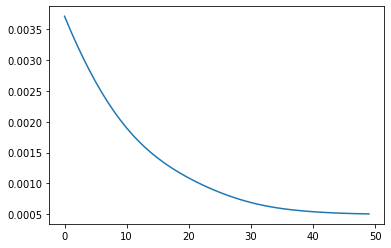

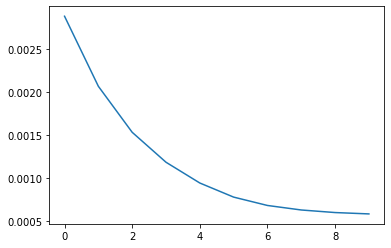

In [54]:
res = do_shit(
    time_series=heart_data,
    cell_type=RSPForecaster,
    inp_size=2,
    hidden_size=5,
    num_cells=1,
    max_epochs=50,
    lr=0.001,
    do_plot=False,
    get_train_val_data_fn=get_train_test_data_heart_rate
)
plt.plot(range(len(res.epoch_errors_train)), res.epoch_errors_train)
plt.figure()
plt.plot(range(len(res.epoch_errors_val)), res.epoch_errors_val)

In [56]:
import pickle
num_cells_choices = [1, 3, 5]
hidden_size_choices = [4, 8, 32]
ts_choices = [(heart_data, 'HR', get_train_test_data_heart_rate),
              (ot_ts, 'ETTH_OT', get_train_test_data_from_ts)]
cell_type_choices = [(RSPForecaster, 'RSP'), (GRUForecaster, 'GRU'), (LSTMForecaster, 'LSTM')]
results_dict = {}

In [57]:
i = 0

for num_cells in num_cells_choices:
    for hidden_size in hidden_size_choices:
        for ts, ts_name, ts_data_process_fn in ts_choices:
            for cell_type, cell_type_name in cell_type_choices:
                print(f'Started training for iter {i}, NC {num_cells}, HS {hidden_size},' +
                      f' TS {ts_name}, CT {cell_type_name}.')
                res = do_shit(ts, cell_type, inp_size=2, hidden_size=hidden_size, num_cells=num_cells,
                             max_epochs=500, lr=0.001, do_plot=False, do_print=False, val_freq=20,
                             get_train_val_data_fn=ts_data_process_fn)
                print('Finished..')
                results_dict[(num_cells, hidden_size, ts_name, cell_type_name)] = res
                print('Updated results dict.')
                with open(f'resultsv2_at_iter_{i}.pkl', 'wb') as f:
                    pickle.dump(results_dict, f)
                print('Serialized current results dict.')
                i += 1

Started training for iter 0, NC 1, HS 4, TS HR, CT RSP.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 1, NC 1, HS 4, TS HR, CT GRU.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 2, NC 1, HS 4, TS HR, CT LSTM.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 3, NC 1, HS 4, TS ETTH_OT, CT RSP.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 4, NC 1, HS 4, TS ETTH_OT, CT GRU.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 5, NC 1, HS 4, TS ETTH_OT, CT LSTM.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 6, NC 1, HS 8, TS HR, CT RSP.
Finished..
Updated results dict.
Serialized current results dict.
Started training for iter 7, NC 1, HS 8, TS HR, CT GRU.
Finished..
Updated results dict.
Serialized current results dict.
Started

In [59]:
with open(f'resultsv2_at_iter_53.pkl', 'rb') as f:
    deserialized_results_dict = pickle.load(f)
print(len(deserialized_results_dict))
print(len(results_dict))

54
54




FOR num_cells 1 AND hidden_size 4:
Avg epoch time for TS HR CT RSP: 0.260404298348 seconds.
Avg epoch time for TS HR CT GRU: 0.28890353789999995 seconds.
Avg epoch time for TS HR CT LSTM: 0.33003304706799996 seconds.


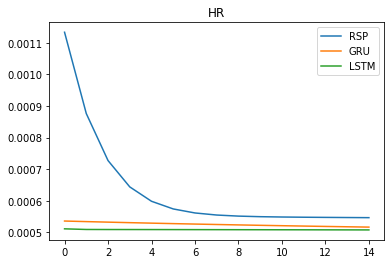

Avg epoch time for TS ETTH_OT CT RSP: 1.459269158218 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 1.68497162895 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 1.937298922956 seconds.


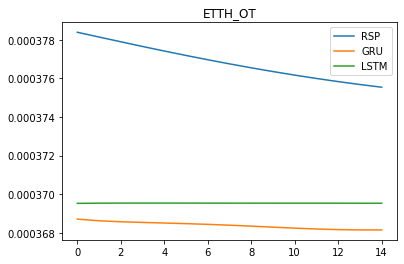



FOR num_cells 1 AND hidden_size 8:
Avg epoch time for TS HR CT RSP: 0.267270342248 seconds.
Avg epoch time for TS HR CT GRU: 0.296515762838 seconds.
Avg epoch time for TS HR CT LSTM: 0.317958949822 seconds.


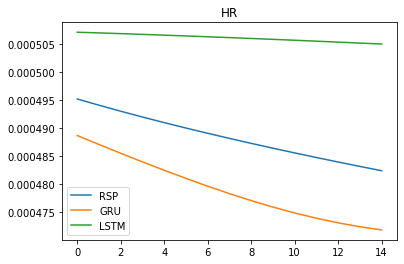

Avg epoch time for TS ETTH_OT CT RSP: 1.446131679846 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 1.6271447933939998 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 1.845104079464 seconds.


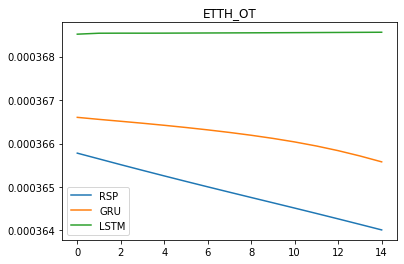



FOR num_cells 1 AND hidden_size 32:
Avg epoch time for TS HR CT RSP: 0.26082212232799995 seconds.
Avg epoch time for TS HR CT GRU: 0.29507405646 seconds.
Avg epoch time for TS HR CT LSTM: 0.329625020606 seconds.


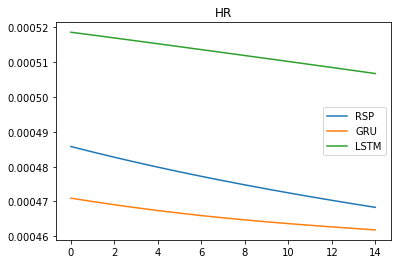

Avg epoch time for TS ETTH_OT CT RSP: 1.4454579803 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 1.625837250134 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 1.9812529034480002 seconds.


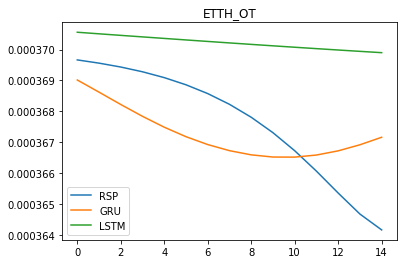



FOR num_cells 3 AND hidden_size 4:
Avg epoch time for TS HR CT RSP: 0.5887327512199999 seconds.
Avg epoch time for TS HR CT GRU: 0.685418398062 seconds.
Avg epoch time for TS HR CT LSTM: 0.8156008877759999 seconds.


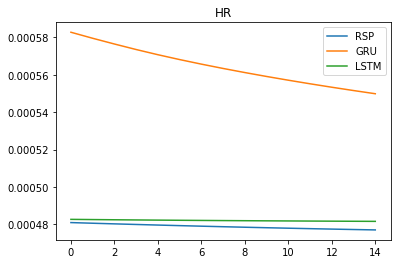

Avg epoch time for TS ETTH_OT CT RSP: 3.304430894346 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 3.90314406991 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 4.65922674588 seconds.


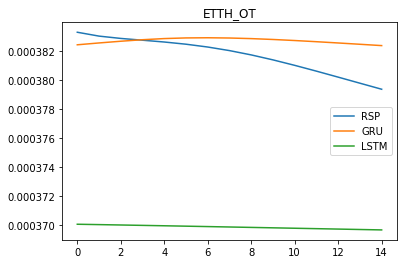



FOR num_cells 3 AND hidden_size 8:
Avg epoch time for TS HR CT RSP: 0.5887979964560001 seconds.
Avg epoch time for TS HR CT GRU: 0.6826172243780001 seconds.
Avg epoch time for TS HR CT LSTM: 0.8097608745620001 seconds.


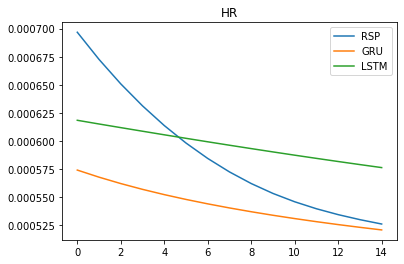

Avg epoch time for TS ETTH_OT CT RSP: 3.28744247502 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 3.9273443299379998 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 4.635650425924 seconds.


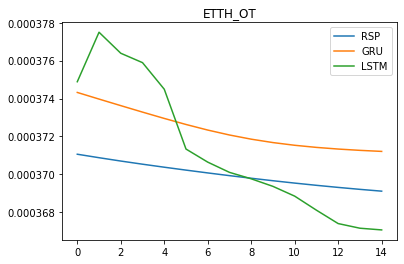



FOR num_cells 3 AND hidden_size 32:
Avg epoch time for TS HR CT RSP: 0.60264777498 seconds.
Avg epoch time for TS HR CT GRU: 0.7054123948359999 seconds.
Avg epoch time for TS HR CT LSTM: 0.852027680842 seconds.


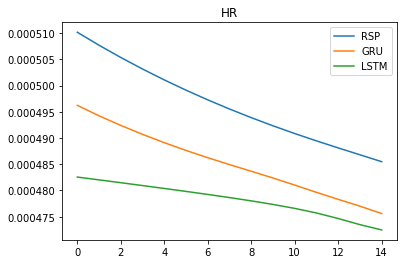

Avg epoch time for TS ETTH_OT CT RSP: 3.3528907605880005 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 3.95965792272 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 5.096941788014 seconds.


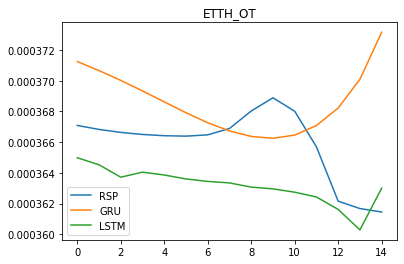



FOR num_cells 5 AND hidden_size 4:
Avg epoch time for TS HR CT RSP: 0.918750335062 seconds.
Avg epoch time for TS HR CT GRU: 1.086680099968 seconds.
Avg epoch time for TS HR CT LSTM: 1.31945216515 seconds.


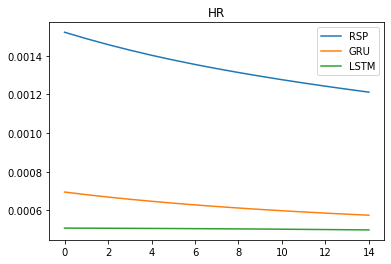

Avg epoch time for TS ETTH_OT CT RSP: 5.238837047382 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 6.181863619608 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 7.68680730652 seconds.


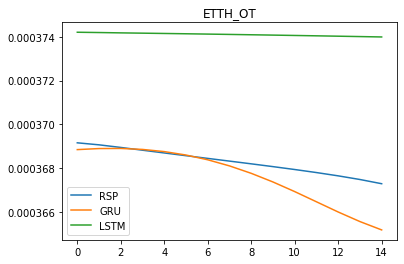



FOR num_cells 5 AND hidden_size 8:
Avg epoch time for TS HR CT RSP: 0.9250518476120001 seconds.
Avg epoch time for TS HR CT GRU: 1.0978209207720002 seconds.
Avg epoch time for TS HR CT LSTM: 1.326365023716 seconds.


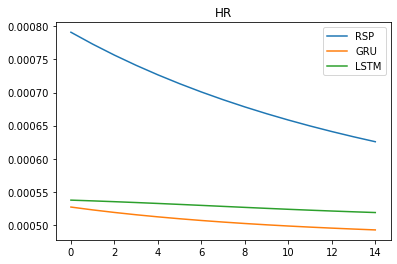

Avg epoch time for TS ETTH_OT CT RSP: 5.208734400026 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 6.156052003588 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 7.602966425578 seconds.


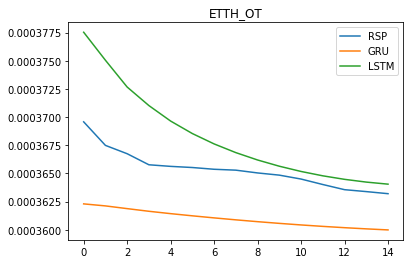



FOR num_cells 5 AND hidden_size 32:
Avg epoch time for TS HR CT RSP: 0.9572284088920001 seconds.
Avg epoch time for TS HR CT GRU: 1.142125116536 seconds.
Avg epoch time for TS HR CT LSTM: 1.377945117108 seconds.


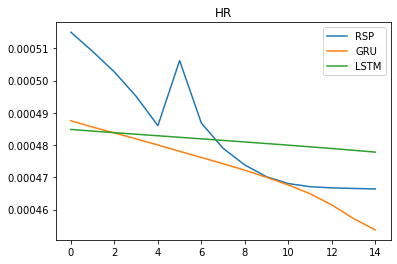

Avg epoch time for TS ETTH_OT CT RSP: 5.314309348886001 seconds.
Avg epoch time for TS ETTH_OT CT GRU: 6.2493057549860005 seconds.
Avg epoch time for TS ETTH_OT CT LSTM: 8.321875679926 seconds.


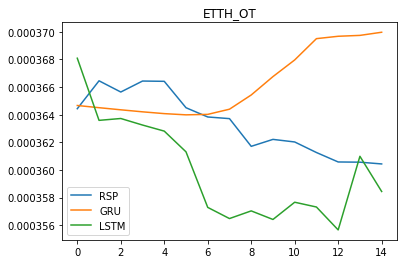

In [61]:
def plot_and_print_stuff(num_cells, hidden_size, res_dict):
    for ts, ts_name, *_ in ts_choices:
        plt.figure()
        plt.title(ts_name)
        for cell_type, cell_type_name in cell_type_choices:
            result = res_dict[(num_cells, hidden_size, ts_name, cell_type_name)]
            N = len(result.epoch_errors_val)
            plt.plot(range(N - 10), result.epoch_errors_val[10:], label=cell_type_name)
            avg_epoch_time = np.array(result.time_per_epoch).mean()
            print(f'Avg epoch time for TS {ts_name} CT {cell_type_name}: {avg_epoch_time} seconds.')
        plt.legend()
        plt.show()            

        
for num_cells in num_cells_choices:
    for hidden_size in hidden_size_choices:
        print(f'\n\nFOR num_cells {num_cells} AND hidden_size {hidden_size}:')
        plot_and_print_stuff(num_cells, hidden_size, deserialized_results_dict)

In [70]:
def get_ts_results_summary_df(results_dict, ts_name):
    df_dict = {'NC': [], 'HS': [], 'CT': [], 'E': [], 'ERTB': [], 'AET': [], 'AETRTB': []}

    for num_cells in num_cells_choices:
        for hidden_size in hidden_size_choices:
            all_best_errors = []
            all_avg_epoch_times = []
            for cell_type, cell_type_name in cell_type_choices:                
                res = results_dict[(num_cells, hidden_size, ts_name, cell_type_name)]
                best_val_err = np.array(res.epoch_errors_val).min()
                all_best_errors.append(best_val_err)
                avg_epoch_time = np.array(res.time_per_epoch).mean()
                all_avg_epoch_times.append(avg_epoch_time)
                df_dict['CT'].append(cell_type_name)
                df_dict['NC'].append(num_cells)
                df_dict['HS'].append(hidden_size)
                df_dict['E'].append(best_val_err)
                df_dict['AET'].append(avg_epoch_time)
            best_best_err = min(all_best_errors)
            best_avg_epoch_time = min(all_avg_epoch_times)
            for i, (cell_type, cell_type_name) in enumerate(cell_type_choices):
                df_dict['ERTB'].append(all_best_errors[i] / best_best_err)
                df_dict['AETRTB'].append(all_avg_epoch_times[i] / best_avg_epoch_time)
    return pd.DataFrame.from_dict(df_dict)

df = get_ts_results_summary_df(deserialized_results_dict, 'HR')
print(len(df))
print(df)

for cell_type, cell_type_name in cell_type_choices:
    all_rel_errors = df[df['CT'] == cell_type_name]['ERTB']
    all_rel_etimes = df[df['CT'] == cell_type_name]['AETRTB']
    print(f'For CT {cell_type_name} avg rel err: {all_rel_errors.mean()}, avg rel etime: {all_rel_etimes.mean()}')

27
    NC  HS    CT         E      ERTB       AET    AETRTB
0    1   4   RSP  0.000547  1.076418  0.260404  1.000000
1    1   4   GRU  0.000517  1.017469  0.288904  1.109442
2    1   4  LSTM  0.000508  1.000000  0.330033  1.267387
3    1   8   RSP  0.000482  1.022309  0.267270  1.000000
4    1   8   GRU  0.000472  1.000000  0.296516  1.109423
5    1   8  LSTM  0.000505  1.070077  0.317959  1.189653
6    1  32   RSP  0.000468  1.014040  0.260822  1.000000
7    1  32   GRU  0.000462  1.000000  0.295074  1.131323
8    1  32  LSTM  0.000507  1.097287  0.329625  1.263792
9    3   4   RSP  0.000477  1.000000  0.588733  1.000000
10   3   4   GRU  0.000550  1.152757  0.685418  1.164227
11   3   4  LSTM  0.000482  1.009591  0.815601  1.385350
12   3   8   RSP  0.000526  1.010098  0.588798  1.000000
13   3   8   GRU  0.000521  1.000000  0.682617  1.159340
14   3   8  LSTM  0.000576  1.106708  0.809761  1.375278
15   3  32   RSP  0.000485  1.027533  0.602648  1.000000
16   3  32   GRU  0.000476  

torch.Size([998, 1, 1]) torch.Size([998, 1, 1])
Metrics for model test:
	 MSE: 0.0003578757168725133
	 MAE: 0.01348005048930645
	 MAPE: 0.06654009222984314


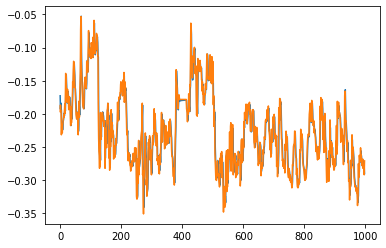

In [136]:
model.set_mode(PRForecaster.MODE_TEST)
with torch.no_grad():
    model_forecasts, _ = run_mod_with_correction_block_on_inputs_with_targets(
        model, test_input, test_target, setup_ctxs=True, delete_ctxs=True, model_mode=PRForecaster.MODE_TEST)
    print(model_forecasts.shape, test_target.shape)
    print_metrics(model_forecasts, test_target, 'model test')
    N, S, one = test_target.shape
    SEQ_IDX = 0
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
    plt.show()

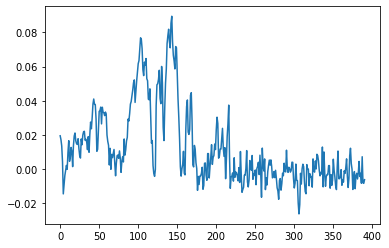

In [46]:
plt.plot(range(len(corrections[10:])), corrections[10:].squeeze())

In [16]:
print('''
loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767
''')


loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767



In [14]:
print(test_target.shape)

torch.Size([4, 88])


In [44]:
'RSP test loss: 0.0006836527948247121'

'RSP test loss: 0.0006836527948247121'

In [46]:
'Linear test loss: 0.00068016676907737'

'Linear test loss: 0.00068016676907737'

In [47]:
def forward_gru(x, hprev, wz, wr, w):
    p = torch.cat((x, hprev), dim=0)
    zt = torch.sigmoid(torch.matmul(wz, p))
    rt = torch.sigmoid(torch.matmul(wr, p))
    pc = torch.cat((rt * hprev, x), dim=0)
    hcand = torch.tanh(torch.matmul(w, pc))
    ht = (1 - zt) * hprev + zt * hcand
    return ht

In [88]:
INP_SIZE = 8
HID_SIZE = 64

import time

N = 100000

total_time = 0
for _ in range(N):
    x = torch.randn(INP_SIZE, 1)
    hprev = torch.randn(HID_SIZE, 1)
    wz = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    wr = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    w = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    start = time.perf_counter_ns()
    t = forward_gru(x, hprev, wz, wr, w)
    end = time.perf_counter_ns()
    total_time += (end - start) / 10**6
print(t.shape)
print(f'Avg time: {total_time / N} milliseconds.')

torch.Size([64, 1])
Avg time: 0.05417328742999968 milliseconds.


In [61]:
def forward_rsp(x, hprev, wc, s):
    p = torch.cat((x, hprev), dim=0)
    zt = torch.sigmoid(torch.matmul(s, p))
    hcand = torch.matmul(wc, p)
    ht = (1 - zt) * hprev + zt * hcand
    return ht

In [89]:
INP_SIZE = 8
HID_SIZE = 64

import time

N = 100000

total_time = 0
for _ in range(N):
    x = torch.randn(INP_SIZE, 1)
    hprev = torch.randn(HID_SIZE, 1)
    s = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    wc = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    start = time.perf_counter_ns()
    t = forward_rsp(x, hprev, wc, s)
    end = time.perf_counter_ns()
    total_time += (end - start) / 10**6
print(t.shape)
print(f'Avg time: {total_time / N} milliseconds.')

torch.Size([64, 1])
Avg time: 0.035580193489999835 milliseconds.


In [63]:
def forward_lstm(x, hprev, cprev, wf, wi, wc, wo):
    p = torch.cat((x, hprev), dim=0)
    ft = torch.sigmoid(torch.matmul(wf, p))
    it = torch.sigmoid(torch.matmul(wi, p))
    ccandt = torch.tanh(torch.matmul(wc, p))
    ct = ft * cprev + it * ccandt
    ot = torch.sigmoid(torch.matmul(wo, p))
    ht = ot * torch.tanh(ct)
    return ht, ct

In [80]:
INP_SIZE = 4
HID_SIZE = 32

import time

N = 100000

total_time = 0
for _ in range(N):
    x = torch.randn(INP_SIZE, 1)
    hprev = torch.randn(HID_SIZE, 1)
    cprev = torch.randn(HID_SIZE, 1)
    wf = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    wi = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    wc = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    wo = torch.randn((HID_SIZE, HID_SIZE + INP_SIZE))
    start = time.perf_counter_ns()
    t = forward_lstm(x, hprev, cprev, wf, wi, wc, wo)
    end = time.perf_counter_ns()
    total_time += (end - start) / 10**6
print(t[0].shape, t[1].shape)
print(f'Avg time: {total_time / N} milliseconds.')

torch.Size([32, 1]) torch.Size([32, 1])
Avg time: 0.041491183200000226 milliseconds.


In [74]:
INP_SIZE = 4
HID_SIZE = 12

import time

N = 100000

total_time = 0
for _ in range(N):
    x = torch.randn(1, INP_SIZE)
    hprev = torch.randn(1, HID_SIZE)
    cprev = torch.randn(1, HID_SIZE)
    lstm = nn.LSTMCell(INP_SIZE, HID_SIZE)
    start = time.perf_counter_ns()
    t = lstm(x, (hprev, cprev))
    end = time.perf_counter_ns()
    total_time += (end - start) / 10**6
print(t[0].shape, t[1].shape)
print(f'Avg time: {total_time / N} milliseconds.')

torch.Size([1, 12]) torch.Size([1, 12])
Avg time: 0.0938717465799989 milliseconds.


In [79]:
INP_SIZE = 4
HID_SIZE = 12

import time

N = 100000

total_time = 0
for _ in range(N):
    x = torch.randn(1, INP_SIZE)
    hprev = torch.randn(1, HID_SIZE)
    gru = nn.GRUCell(INP_SIZE, HID_SIZE)
    start = time.perf_counter_ns()
    t = gru(x, hprev)
    end = time.perf_counter_ns()
    total_time += (end - start) / 10**6
print(t.shape)
print(f'Avg time: {total_time / N} milliseconds.')

torch.Size([1, 12])
Avg time: 0.10393364077999984 milliseconds.


In [90]:
speedups = np.array([0.0355/0.054, 0.032/0.0487, 0.0327/0.0503, 0.0317/0.0492, 0.032/0.057])

In [93]:
(1/speedups).mean()

1.582905706688738

In [94]:
speedups.mean()

0.6340606903518002